### Задача
Прогнозирование вероятности возникновения инсульта у человека.

#### Информация об атрибутах
- id: уникальный идентификатор.
- gender: пол: мужской, женский, другое.
- age: возраст пациента.
- hypertension: диагностирована ли у пациента гипертония (0 - нет, 1 - да).
- heart_disease: диагностированы ли у пациента болезни сердца (0 - нет, 1 - да).
- ever married: был ли пациента когда-либо женат/замужем.
- work-type: вид работы (работа с детьми, работа на государственной службе, никогда не работал(а), частная работа, самозанятый(ая)).
- Residence_type: место жительства (сельская местность, город).
- avg_glucose_level: средний уровень глюкозы в крови.
- bmi: значение ИМТ - индекса массы тела.
- smoking_status: отношение к курению (курил(а) в прошлом, никогда не курил(а), курит в настоящий момент, инофрмация неизвестна).
- stroke: таргетный признак, выявлен инсульт или нет (0 - нет, 1 - да). 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

### Чтение данных

In [2]:
dataset = pd.read_csv("./healthcare-dataset-stroke-data.csv")

In [3]:
dataset.drop('id', axis=1, inplace=True)
dataset

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


### Визуализация данных и вычисление основных характеристик

Возрастное распределение

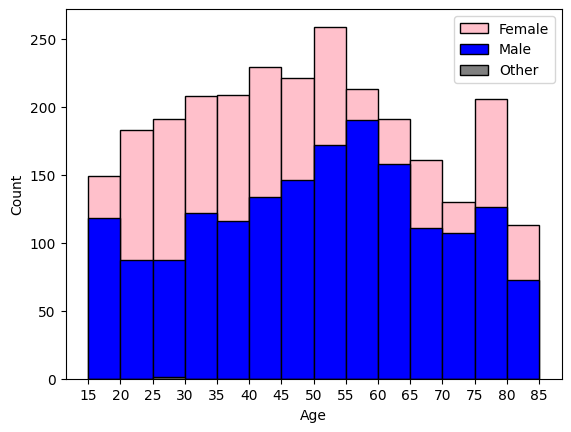

In [5]:
plt.hist(dataset['age'].loc[dataset['gender'] == 'Female'], bins=np.arange(15, 90, 5), color='pink', edgecolor='black', label="Female")
plt.hist(dataset['age'].loc[dataset['gender'] == 'Male'], bins=np.arange(15, 90, 5), color='blue', edgecolor='black', label="Male")
plt.hist(dataset['age'].loc[dataset['gender'] == 'Other'], bins=np.arange(15, 90, 5), color='gray', edgecolor='black',  label="Other")
plt.xticks(np.arange(15, 90, 5))
plt.yticks()

plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()
plt.show()

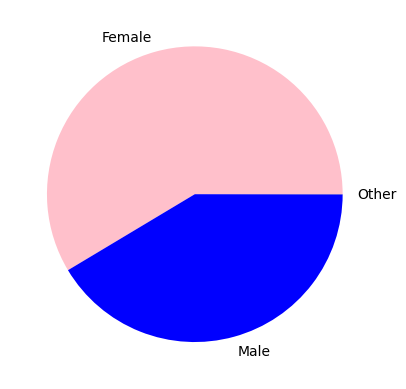

In [6]:
plt.pie(dataset['gender'].value_counts(), labels=['Female', 'Male', 'Other'], colors = ['pink', 'blue', 'gray'])
plt.show()

Индекс массы тела

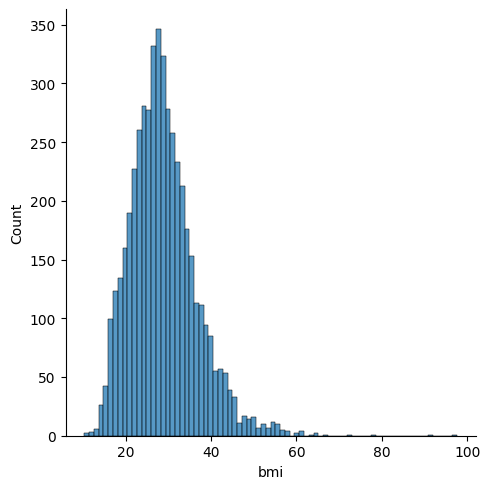

In [7]:
sns.displot(dataset['bmi'])
plt.show()

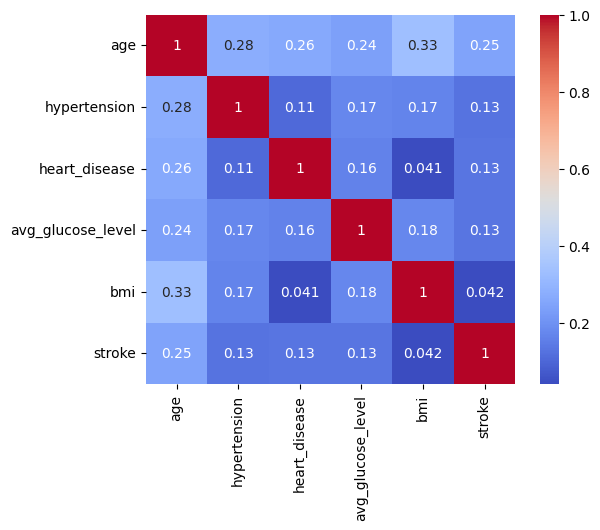

In [8]:
sns.heatmap(dataset.corr(numeric_only=True), annot=True, square=True, cmap='coolwarm')
pass

### Обработка пропущенных значений

In [9]:
dataset.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [10]:
dataset['bmi'] = dataset['bmi'].fillna(dataset['bmi'].median(axis = 0), axis = 0)
dataset.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### Обработка категориальных признаков

In [11]:
categorical_columns = [i for i in dataset.columns if dataset[i].dtype == 'object']
numerical_columns = [i for i in dataset.columns if dataset[i].dtype != 'object' and i != 'stroke']
print(categorical_columns)
print(numerical_columns)

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']


In [12]:
binary_columns = [i for i in categorical_columns if len(dataset[i].unique()) == 2]
nonbinary_columns = [i for i in categorical_columns if len(dataset[i].unique()) > 2]
print(binary_columns, nonbinary_columns)

['ever_married', 'Residence_type'] ['gender', 'work_type', 'smoking_status']


#### Обработка бинарных категориальных признаков

In [13]:
print(dataset['Residence_type'].unique(), dataset['ever_married'].unique())

['Urban' 'Rural'] ['Yes' 'No']


In [14]:
dataset['Residence_type'] = dataset['Residence_type'].apply(lambda x: 1 if x == 'Urban' else 0)
dataset['ever_married'] = dataset['ever_married'].apply(lambda x: 1 if x == 'Yes' else 0)
dataset

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,1,Self-employed,0,202.21,28.1,never smoked,1
2,Male,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
3,Female,49.0,0,0,1,Private,1,171.23,34.4,smokes,1
4,Female,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,1,Private,1,83.75,28.1,never smoked,0
5106,Female,81.0,0,0,1,Self-employed,1,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,1,Self-employed,0,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,1,Private,0,166.29,25.6,formerly smoked,0


#### Обработка небинарных категориальных признаков

In [15]:
dataset_nonbinary = pd.get_dummies(dataset[nonbinary_columns])
print(dataset_nonbinary.columns)

Index(['gender_Female', 'gender_Male', 'gender_Other', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype='object')


### Нормализация

In [16]:
dataset_numerical = dataset[numerical_columns]
dataset_numerical.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.862035
std,22.612647,0.296607,0.226063,45.283560,7.699562
min,0.080000,0.000000,0.000000,55.120000,10.300000
25%,25.000000,0.000000,0.000000,77.245000,23.800000
50%,45.000000,0.000000,0.000000,91.885000,28.100000
75%,61.000000,0.000000,0.000000,114.090000,32.800000
max,82.000000,1.000000,1.000000,271.740000,97.600000


In [17]:
dataset_numerical = (dataset_numerical - dataset_numerical.mean(axis = 0))/dataset_numerical.std(axis = 0)
dataset_numerical.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi
count,5.110000e+03,5.110000e+03,5.110000e+03,5.110000e+03,5.110000e+03
mean,3.893385e-17,2.780989e-18,3.615286e-17,1.001156e-16,-4.171484e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.908074e+00,-3.285697e-01,-2.389234e-01,-1.126848e+00,-2.410791e+00
25%,-8.060363e-01,-3.285697e-01,-2.389234e-01,-6.382598e-01,-6.574445e-01
50%,7.842450e-02,-3.285697e-01,-2.389234e-01,-3.149637e-01,-9.897124e-02
75%,7.859932e-01,-3.285697e-01,-2.389234e-01,1.753909e-01,5.114531e-01
max,1.714677e+00,3.042899e+00,4.184622e+00,3.656787e+00,8.927516e+00


In [18]:
dataset = pd.concat([dataset_numerical, dataset_nonbinary, dataset[binary_columns], dataset['stroke']], axis = 1)
dataset

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,ever_married,Residence_type,stroke
0,1.051331,-0.328570,4.184622,2.706111,1.004988,False,True,False,False,False,True,False,False,False,True,False,False,1,1,1
1,0.785993,-0.328570,-0.238923,2.121351,-0.098971,True,False,False,False,False,False,True,False,False,False,True,False,1,0,1
2,1.626231,-0.328570,4.184622,-0.005028,0.472490,False,True,False,False,False,True,False,False,False,False,True,False,1,0,1
3,0.255317,-0.328570,-0.238923,1.437217,0.719257,True,False,False,False,False,True,False,False,False,False,False,True,1,1,1
4,1.582008,3.042899,-0.238923,1.501038,-0.631469,True,False,False,False,False,False,True,False,False,False,True,False,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,1.626231,3.042899,-0.238923,-0.494609,-0.098971,True,False,False,False,False,True,False,False,False,False,True,False,1,1,0
5106,1.670454,-0.328570,-0.238923,0.420734,1.446571,True,False,False,False,False,False,True,False,False,False,True,False,1,1,0
5107,-0.363806,-0.328570,-0.238923,-0.511393,0.225723,True,False,False,False,False,False,True,False,False,False,True,False,1,0,0
5108,0.343763,-0.328570,-0.238923,1.328127,-0.423665,False,True,False,False,False,True,False,False,False,True,False,False,1,0,0


### Разбивка данных

In [19]:
X = dataset.drop(['stroke'], axis = 1)
y = dataset['stroke']
X = X.to_numpy()
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 21)

N_train = X_train.shape[0]
N_test = X_test.shape[0]
print(N_train, N_test)

3577 1533


### Запуск классификатора ближайших соседей

In [20]:
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, y_train)

y_test_predicted = knn.predict(X_test)
err_test = np.mean(y_test_predicted != y_test)

y_train_predict = knn.predict(X_train)
err_train = np.mean(y_train != y_train_predict)

print('err_test=', err_test)
print('err_train=', err_train)

accurancy_train = accuracy_score(y_train, y_train_predict)
accurancy_test = accuracy_score(y_test, y_test_predicted)

print('accurancy_test=', accurancy_test)
print('accurancy_train=', accurancy_train)

err_test= 0.0502283105022831
err_train= 0.048084987419625386
accurancy_test= 0.9497716894977168
accurancy_train= 0.9519150125803746


### Поиск оптимального значения гиперпараметра (к- ближайших соседей)

In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
knn = KNeighborsClassifier()

param = np.arange(1, 10)
params = {
    'n_neighbors': param
}

gs = GridSearchCV(knn,params, n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [23]:
gs.best_params_

{'n_neighbors': np.int64(6)}

### Вычислений ошибок на обучающей и тестовой выборках

In [24]:
knn = KNeighborsClassifier(**gs.best_params_)

knn.fit(X_train, y_train)

y_test_predicted = knn.predict(X_test)
err_test = np.mean(y_test_predicted != y_test)

y_train_predict = knn.predict(X_train)
err_train = np.mean(y_train != y_train_predict)

print('err_test=', err_test)
print('err_train=', err_train)

accurancy_train = accuracy_score(y_train, y_train_predict)
accurancy_test = accuracy_score(y_test, y_test_predicted)

print('accurancy_test=', accurancy_test)
print('accurancy_train=', accurancy_train)

err_test= 0.04957599478147423
err_train= 0.048084987419625386
accurancy_test= 0.9504240052185258
accurancy_train= 0.9519150125803746


### RandomForest

In [25]:
from sklearn import ensemble

In [26]:
rf = ensemble.RandomForestClassifier(n_estimators = 500, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [27]:
y_test_predicted = rf.predict(X_test)
err_test = np.mean(y_test_predicted != y_test)

y_train_predict = rf.predict(X_train)
err_train = np.mean(y_train != y_train_predict)

print('err_test=', err_test)
print('err_train=', err_train)

accurancy_train = accuracy_score(y_train, y_train_predict)
accurancy_test = accuracy_score(y_test, y_test_predicted)

print('accurancy_test=', accurancy_test)
print('accurancy_train=', accurancy_train)

err_test= 0.051532941943900845
err_train= 0.0
accurancy_test= 0.9484670580560991
accurancy_train= 1.0


### Выводы

В работе реализовано обучение модели машинного обучения посредством метода k ближайших соседей и Random Forest. 
Наименьшую ошибку показал метод k ближайших соседей со значением параметра = 6.